In [0]:
## import required packages

# basic python libraries 
import os, sys, math

# data handling
import pandas as pd # data processing, CSV file I/O, data manipulation as in SQL
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import numpy as np # linear algebra

# graph plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns 
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# statistics
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf

# machine learning
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.preprocessing import MinMaxScaler # for normalization
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# deep learning
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
# merged two columns 'Date' and 'Time' to 'datetime'
# convert those data to time-series type, by convert 'datetime' as an index
dataset_path = '/content/drive/My Drive/Colab Notebooks/household_power_consumption.csv'
df = pd.read_csv(dataset_path, parse_dates = True, index_col = 'datetime', low_memory = False)

In [0]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.2160,0.4180,234.8400,18.4000,0.0000,1.0000,17.0000
2006-12-16 17:25:00,5.3600,0.4360,233.6300,23.0000,0.0000,1.0000,16.0000
2006-12-16 17:26:00,5.3740,0.4980,233.2900,23.0000,0.0000,2.0000,17.0000
2006-12-16 17:27:00,5.3880,0.5020,233.7400,23.0000,0.0000,1.0000,17.0000
2006-12-16 17:28:00,3.6660,0.5280,235.6800,15.8000,0.0000,1.0000,17.0000


In [0]:
df.shape

(2075259, 7)

In [0]:
# get values
dataset = df.Global_active_power.values
dataset = dataset.astype('float32')

# reshape
dataset = np.reshape(dataset, (-1, 1))

# normalize
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split data
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [0]:
train

array([[0.37479633],
       [0.47836325],
       [0.47963068],
       ...,
       [0.01828716],
       [0.02426218],
       [0.02335687]], dtype=float32)

In [0]:
test

array([[0.02353793],
       [0.02335687],
       [0.02335687],
       ...,
       [0.07803731],
       [0.07767518],
       [0.07749411]], dtype=float32)

In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [0]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [0]:
X_train.shape

(1660176, 30)

In [0]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [0]:
X_train.shape

(1660176, 1, 30)

In [0]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1660176 samples, validate on 415021 samples
Epoch 1/20
1660176/1660176 [==============================] - 147s 89us/sample - loss: 7.6127e-04 - val_loss: 3.9072e-04
Epoch 2/20
1660176/1660176 [==============================] - 143s 86us/sample - loss: 6.6105e-04 - val_loss: 3.8210e-04
Epoch 3/20
1660176/1660176 [==============================] - 143s 86us/sample - loss: 6.5152e-04 - val_loss: 3.8128e-04
Epoch 4/20
1660176/1660176 [==============================] - 141s 85us/sample - loss: 6.4457e-04 - val_loss: 3.8121e-04
Epoch 5/20
1660176/1660176 [==============================] - 143s 86us/sample - loss: 6.3955e-04 - val_loss: 3.8077e-04
Epoch 6/20
1660176/1660176 [==============================] - 140s 84us/sample - loss: 6.3599e-04 - val_loss: 3.7879e-04
Epoch 7/20
1660176/1660176 [==================

In [0]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.10317662910811236
Train Root Mean Squared Error: 0.26531286633953105
Test Mean Absolute Error: 0.08504515461079583
Test Root Mean Squared Error: 0.21402822123636867


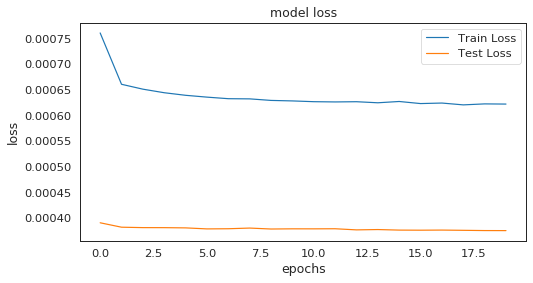

In [0]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

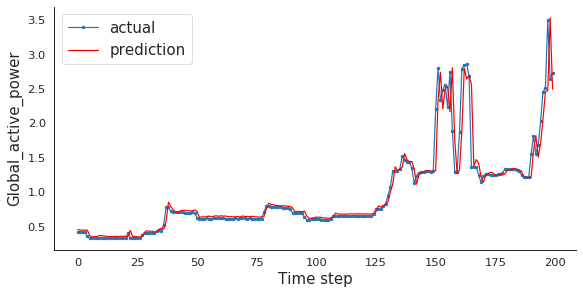

In [0]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();